# Customer Segmentation

##Customer Personality Analysis
Customer personality analysis helps a business to modify its product based on its target customers from different types of customer segments. For example, instead of spending money to market a new product to every customer in the company’s database, a company can analyze which customer segment is most likely to buy the product and then market the product only on that particular segment.

## Package imports

In [ ]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.colors import ListedColormap
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt, numpy as np
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import AgglomerativeClustering
from matplotlib.colors import ListedColormap
from sklearn import metrics
import plotly.express as px

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/project/project_3

Mounted at /content/drive
/content/drive/MyDrive/project/project_3


### Data set import
The data set has already been cleaned using the Python script `clean.py`

In [ ]:
path = './data/marketing_campaign.csv'
df = pd.read_csv(path, sep = '\t')

df.head(10)

ID  Year_Birth   Education Marital_Status   Income  Kidhome  Teenhome  \
0  5524        1957  Graduation         Single  58138.0        0         0   
1  2174        1954  Graduation         Single  46344.0        1         1   
2  4141        1965  Graduation       Together  71613.0        0         0   
3  6182        1984  Graduation       Together  26646.0        1         0   
4  5324        1981         PhD        Married  58293.0        1         0   
5  7446        1967      Master       Together  62513.0        0         1   
6   965        1971  Graduation       Divorced  55635.0        0         1   
7  6177        1985         PhD        Married  33454.0        1         0   
8  4855        1974         PhD       Together  30351.0        1         0   
9  5899        1950         PhD       Together   5648.0        1         1   

  Dt_Customer  Recency  MntWines  ...  NumWebVisitsMonth  AcceptedCmp3  \
0  04-09-2012       58       635  ...                  7             0   
1  08-03-2014       38        11  ...                  5             0   
2  21-08-2013       26       426  ...                  4             0   
3  10-02-2014       26        11  ...                  6             0   
4  19-01-2014       94       173  ...                  5             0   
5  09-09-2013       16       520  ...                  6             0   
6  13-11-2012       34       235  ...                  6             0   
7  08-05-2013       32        76  ...                  8             0   
8  06-06-2013       19        14  ...                  9             0   
9  13-03-2014       68        28  ...                 20             1   

   AcceptedCmp4  AcceptedCmp5  AcceptedCmp1  AcceptedCmp2  Complain  \
0             0             0             0             0         0   
1             0             0             0             0         0   
2             0             0             0             0         0   
3             0             0             0             0         0   
4             0             0             0             0         0   
5             0             0             0             0         0   
6             0             0             0             0         0   
7             0             0             0             0         0   
8             0             0             0             0         0   
9             0             0             0             0         0   

   Z_CostContact  Z_Revenue  Response  
0              3         11         1  
1              3         11         0  
2              3         11         0  
3              3         11         0  
4              3         11         0  
5              3         11         0  
6              3         11         0  
7              3         11         0  
8              3         11         1  
9              3         11         0  

[10 rows x 29 columns]

Clustering objective

Group 1: average income, average spending, high count -> average(2nd priority)

Group 2: low income, low spending, big family size, younger, no accepted offers -> weakly interested (4th priority)

Group 3: high income, high spending, small family size, more accepted offers -> rich (1st priority)

Group 4: average income, below average spending, less educated, younger, low count -> young (3rd priority)

## Feature Engineering

In [ ]:
df["Dt_Customer"] = pd.to_datetime(df["Dt_Customer"])
dates = []
for value in df["Dt_Customer"]:
    value = value.date()
    dates.append(value)

print("Oldest customer join date: ", min(dates))
print("Newest customer join date:", max(dates))

# Get newest customer date
number_of_days = []
ref_date = max(dates)
for d in dates:
    delta = ref_date - d
    number_of_days.append(delta)

# Create 'Customer_For' feature
df["Customer_For"] = number_of_days
df["Customer_For"] = pd.to_numeric(df["Customer_For"], errors="raise")



Oldest customer join date:  2012-01-08
Newest customer join date: 2014-12-06


<ipython-input-4-ff2551d7b33d>:1: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  df["Dt_Customer"] = pd.to_datetime(df["Dt_Customer"])


Explore unique values in categorical features to get a clearer picture of data

In [ ]:
print("Marital_Status:\n", df["Marital_Status"].value_counts(), "\n")
print("Education:\n", df["Education"].value_counts(), "\n")

Marital_Status:
 Married     864
Together    580
Single      480
Divorced    232
Widow        77
Alone         3
Absurd        2
YOLO          2
Name: Marital_Status, dtype: int64 

Education:
 Graduation    1127
PhD            486
Master         370
2n Cycle       203
Basic           54
Name: Education, dtype: int64 



At "Marital_Status" its value not clear meaning, so I change its value to "Together" and "Alone"

Same with "Education" I will change its value to "Undergraduate", "Graduation", "Postgraduate"


### Further feature engineering

In [ ]:
# Age of customers as of 01/11/2023
df["Age"] = 2023 - df["Year_Birth"]

# Total amount spend
df["Spent"] = df["MntWines"] + df["MntFruits"] + df["MntMeatProducts"] + \
    df["MntFishProducts"] + df["MntSweetProducts"] + df["MntGoldProds"]

# Derive household living situation by marital status
df["Living_With"] = df["Marital_Status"].replace(
    {"Married": "Partner",
     "Together": "Partner",
     "Absurd": "Alone",
     "Widow": "Alone",
     "YOLO:": "Alone",
     "Divorced": "Alone",
     "Single": "Alone",
     })

# Total children living at home
df["Children"] = df["Kidhome"] + df["Teenhome"]

# Total household members
df["Family_Size"] = df["Living_With"].map(
    {"Alone":1,
     "Partner":2}
) + df["Children"]

# Drop NAs acquired due to failed parsings
df["Family_Size"].dropna().astype(int)

# Parenthood feature
df["Is_Parent"] = np.where(df.Children > 0, 1, 0)

# Divide education levels in three categories
df["Education"] = df["Education"].replace(
    {"Basic": "Undergraduate",
     "2n Cycle": "Undergraduate",
     "Graduation": "Graduate",
     "Master": "Postgraduate",
     "PhD": "Postgraduate"}
)

#For clarity
df["Frequency"] = df["NumDealsPurchases"] + df["NumWebPurchases"] + df["NumCatalogPurchases"]+df["NumStorePurchases"]

#Total spendings on vatious items
df["Monetary"] = df["MntWines"]+ df["MntFruits"]+ df["MntMeatProducts"]+ df["MntFishProducts"]+ df["MntSweetProducts"]+ df["MntGoldProds"]

# # Improve clarity
# data = data.rename(columns={"MntWines": "Wines",
#                             "MntFruits": "Fruits",
#                             "MntFishProducts": "Fish",
#                             "MntSweetProducts": "Sweets",
#                             "MntGoldProducts": "Gold"}
#                    )

# Drop redundant features
to_drop = ["Marital_Status", "Dt_Customer", "Z_CostContact", "Z_Revenue",
           "Year_Birth", "ID",
#
           "MntWines", "MntFruits", "MntFishProducts", "MntMeatProducts",
           "MntSweetProducts", "MntGoldProds", "NumDealsPurchases",
           "NumWebPurchases", "NumCatalogPurchases", "NumStorePurchases", "NumWebVisitsMonth"]
df = df.drop(to_drop, axis=1)

In [ ]:
df.describe()

Income      Kidhome     Teenhome      Recency  AcceptedCmp3  \
count    2216.000000  2240.000000  2240.000000  2240.000000   2240.000000   
mean    52247.251354     0.444196     0.506250    49.109375      0.072768   
std     25173.076661     0.538398     0.544538    28.962453      0.259813   
min      1730.000000     0.000000     0.000000     0.000000      0.000000   
25%     35303.000000     0.000000     0.000000    24.000000      0.000000   
50%     51381.500000     0.000000     0.000000    49.000000      0.000000   
75%     68522.000000     1.000000     1.000000    74.000000      0.000000   
max    666666.000000     2.000000     2.000000    99.000000      1.000000   

       AcceptedCmp4  AcceptedCmp5  AcceptedCmp1  AcceptedCmp2     Complain  \
count   2240.000000   2240.000000   2240.000000   2240.000000  2240.000000   
mean       0.074554      0.072768      0.064286      0.013393     0.009375   
std        0.262728      0.259813      0.245316      0.114976     0.096391   
min        0.000000      0.000000      0.000000      0.000000     0.000000   
25%        0.000000      0.000000      0.000000      0.000000     0.000000   
50%        0.000000      0.000000      0.000000      0.000000     0.000000   
75%        0.000000      0.000000      0.000000      0.000000     0.000000   
max        1.000000      1.000000      1.000000      1.000000     1.000000   

          Response  Customer_For          Age        Spent     Children  \
count  2240.000000  2.240000e+03  2240.000000  2240.000000  2240.000000   
mean      0.149107  4.424054e+16    54.194196   605.798214     0.950446   
std       0.356274  2.006466e+16    11.984069   602.249288     0.751803   
min       0.000000  0.000000e+00    27.000000     5.000000     0.000000   
25%       0.000000  2.944080e+16    46.000000    68.750000     0.000000   
50%       0.000000  4.432320e+16    53.000000   396.000000     1.000000   
75%       0.000000  5.920560e+16    64.000000  1045.500000     1.000000   
max       1.000000  9.184320e+16   130.000000  2525.000000     3.000000   

       Family_Size    Is_Parent    Frequency     Monetary  
count  2238.000000  2240.000000  2240.000000  2240.000000  
mean      2.595621     0.715179    14.862054   605.798214  
std       0.907190     0.451430     7.677173   602.249288  
min       1.000000     0.000000     0.000000     5.000000  
25%       2.000000     0.000000     8.000000    68.750000  
50%       3.000000     1.000000    15.000000   396.000000  
75%       3.000000     1.000000    21.000000  1045.500000  
max       5.000000     1.000000    44.000000  2525.000000

Some discrepancies are observed in the mean Income and Age features, as well as the max Income and Age.

Note: Max age is 130 years as it is caclculated as of today 2023 and the data has not been collected very recently.

<Figure size 800x550 with 0 Axes>

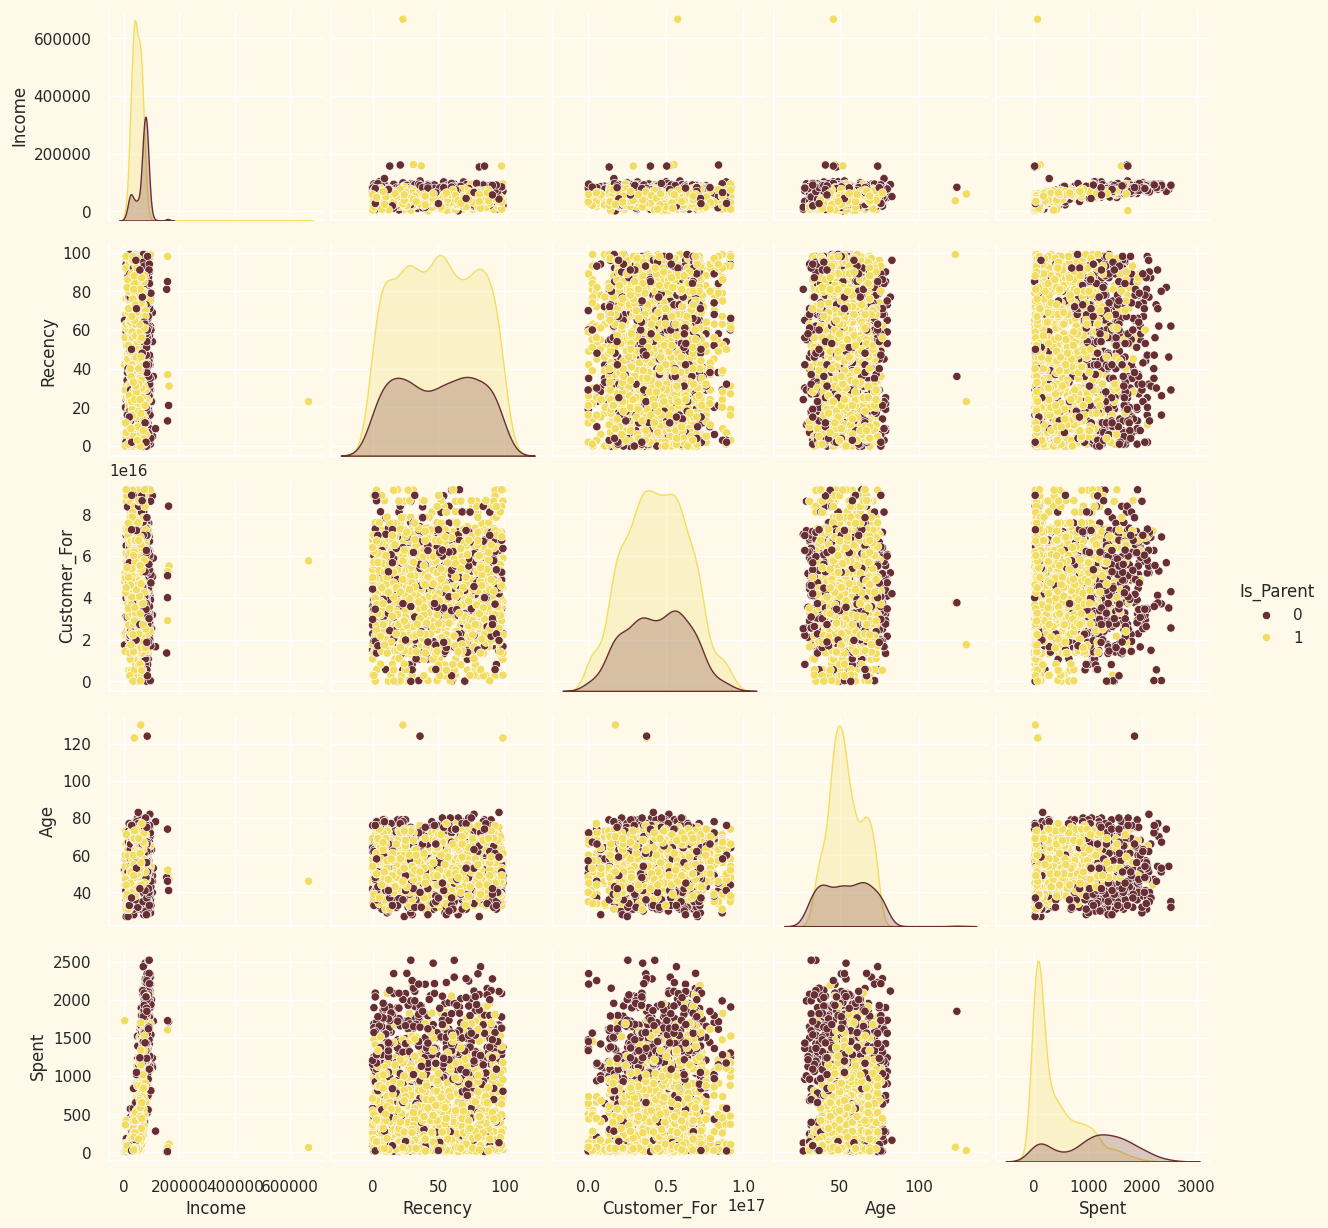

In [ ]:
# Plot select features for visual analysis

# Set up colours
sns.set(rc={
    "axes.facecolor":"#FFF9EA",
    "figure.facecolor":"#FFF9EA"
})
pallet = ["#682F33", "#9E713A", "#D3B3B1", "#B9C0C9", "#9F8A78", "#F3DD60"]
cmap = colors.ListedColormap(pallet)

# Plot features
feats = ["Income", "Recency", "Customer_For", "Age", "Spent", "Is_Parent"]

plt.figure()
sns.pairplot(df[feats], hue = "Is_Parent", palette = (["#682F33", "#F3DD60"]))
plt.show()

There are some outliers in the Age and Income features.

In [ ]:
# Drop outliers by setting limits on Income and Age
df = df[(df["Age"] < 90)]
df = df[(df["Income"] < 600000)]

Analysis of correlation amongst features (quantitative attributes only)

<ipython-input-12-260a45270b1f>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  cm_plot = df.corr()


<Axes: >

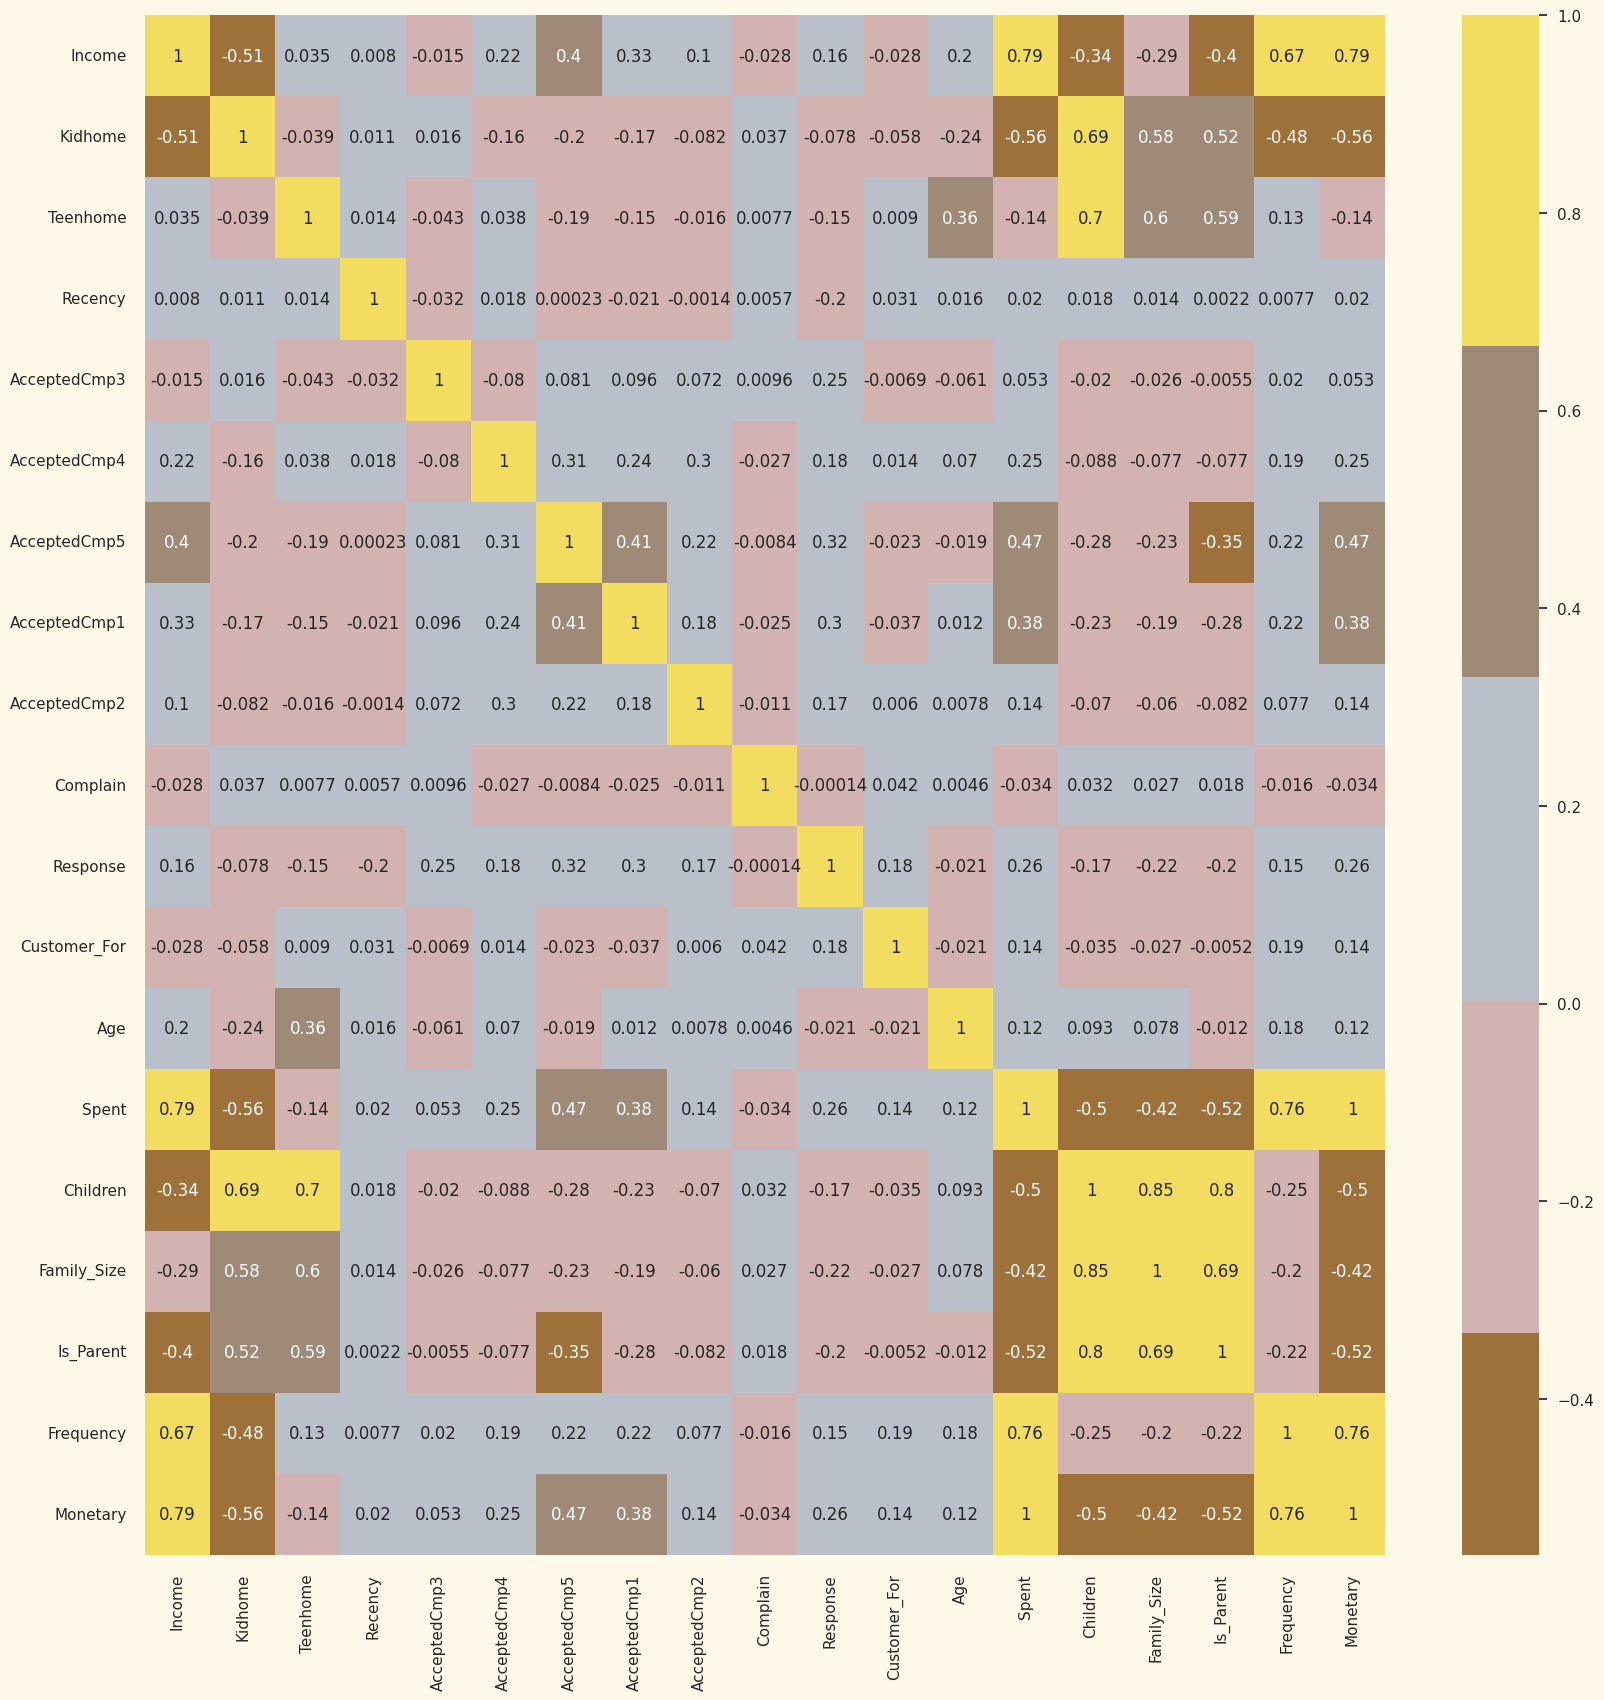

In [ ]:
cm_plot = df.corr()
plt.figure(figsize=(20,20))
sns.heatmap(cm_plot, annot=True, cmap=cmap, center=0)

New features have been included and the data has been cleaned.

## Data Preprocessing

In [ ]:
# Build a list of categorical variables
objs = (df.dtypes == 'object')
object_cols = list(objs[objs].index)

print("Categorical variables: ", object_cols)

# Label encode object dtypes
LabEnc = LabelEncoder()
for obj in object_cols:
    df[obj] = df[[obj]].apply(LabEnc.fit_transform)

Categorical variables:  ['Education', 'Living_With']


All features have been encoded to numerical values.

In [ ]:
missing_values = df.isna().sum()
missing_values

Education       0
Income          0
Kidhome         0
Teenhome        0
Recency         0
AcceptedCmp3    0
AcceptedCmp4    0
AcceptedCmp5    0
AcceptedCmp1    0
AcceptedCmp2    0
Complain        0
Response        0
Customer_For    0
Age             0
Spent           0
Living_With     0
Children        0
Family_Size     2
Is_Parent       0
Frequency       0
Monetary        0
dtype: int64

In [ ]:
df = df.fillna(0)

In [ ]:
# Subset dataframe
df_subset = df.copy()

cols_delete = ["AcceptedCmp3", "AcceptedCmp4", "AcceptedCmp5", "AcceptedCmp1",
                "AcceptedCmp2", "Complain", "Response"]

df_subset = df_subset.drop(cols_delete, axis=1)

# Scale data
scaler = StandardScaler()
scaler.fit(df_subset)
scaled_df = pd.DataFrame(scaler.transform(df_subset), columns=df_subset.columns)

All features have now been scaled.

In [ ]:
scaled_df.describe()

Education        Income       Kidhome      Teenhome       Recency  \
count  2.212000e+03  2.212000e+03  2.212000e+03  2.212000e+03  2.212000e+03   
mean   1.445498e-17 -1.252765e-16  4.175884e-17  9.636656e-17  4.015273e-18   
std    1.000226e+00  1.000226e+00  1.000226e+00  1.000226e+00  1.000226e+00   
min   -8.935862e-01 -2.333791e+00 -8.227535e-01 -9.296987e-01 -1.694030e+00   
25%   -8.935862e-01 -7.771113e-01 -8.227535e-01 -9.296987e-01 -8.646302e-01   
50%   -8.935862e-01 -2.731156e-02 -8.227535e-01 -9.296987e-01 -6.717941e-04   
75%    5.716567e-01  7.679525e-01  1.040021e+00  9.080971e-01  8.632866e-01   
max    2.036900e+00  5.131311e+00  2.902796e+00  2.745893e+00  1.727245e+00   

       Customer_For           Age         Spent   Living_With      Children  \
count  2.212000e+03  2.212000e+03  2.212000e+03  2.212000e+03  2.212000e+03   
mean  -1.397315e-16  6.183521e-17  5.942604e-17 -4.336495e-17  2.248553e-17   
std    1.000226e+00  1.000226e+00  1.000226e+00  1.000226e+00  1.000226e+00   
min   -2.202781e+00 -2.315280e+00 -9.998189e-01 -1.349618e+00 -1.264598e+00   
25%   -7.404087e-01 -6.912026e-01 -8.935732e-01 -1.349618e+00 -1.264598e+00   
50%    3.680820e-03 -9.285849e-02 -3.490638e-01  7.351271e-01  6.998729e-02   
75%    7.477704e-01  8.473966e-01  7.316544e-01  7.351271e-01  6.998729e-02   
max    2.369283e+00  2.471473e+00  3.183607e+00  2.819872e+00  2.739158e+00   

        Family_Size     Is_Parent     Frequency      Monetary  
count  2.212000e+03  2.212000e+03  2.212000e+03  2.212000e+03  
mean   6.745659e-17  1.606109e-17 -8.030546e-18  5.942604e-17  
std    1.000226e+00  1.000226e+00  1.000226e+00  1.000226e+00  
min   -2.850098e+00 -1.581139e+00 -1.941552e+00 -9.998189e-01  
25%   -6.503713e-01 -1.581139e+00 -8.985131e-01 -8.935732e-01  
50%    4.494921e-01  6.324555e-01  1.414610e-02 -3.490638e-01  
75%    4.494921e-01  6.324555e-01  7.964254e-01  7.316544e-01  
max    2.649219e+00  6.324555e-01  3.795163e+00  3.183607e+00

## Dimensionality Reduction

The final classification to be applied is based on several factors - basically, features. A higher number of features increases the difficulty of implementation. Since many such features are related, many of them are therefore redundant. Therefore, a suitable solution to this is dimensionality reudction on selected features before classification.

*Dimensionality reduction is the process of reducing the number of random variables under consideration, by obtaining a set of principal variables.*

A common technique for reducing dimensionality of data sets is **Principal Component Analysis (PCA)**. This technique improves readability with minimal loss of data.

For this data set, the dimensionality will be reduced to 3.

In [ ]:
pca = PCA(n_components=3)
scaled_df.dropna(inplace=True)
pca.fit(scaled_df)
PCA_df = pd.DataFrame(pca.transform(scaled_df), columns=(["col1", "col2", "col3"]))
PCA_df.describe().T

count          mean       std       min       25%       50%       75%  \
col1  2212.0  1.284887e-17  2.257022 -4.824947 -1.912180 -0.263264  1.573849   
col2  2212.0 -1.027910e-16  1.540071 -4.098806 -1.256216  0.062949  1.096863   
col3  2212.0 -1.284887e-17  1.102436 -2.277290 -0.883176 -0.182164  0.898119   

           max  
col1  5.837269  
col2  5.309093  
col3  2.818004

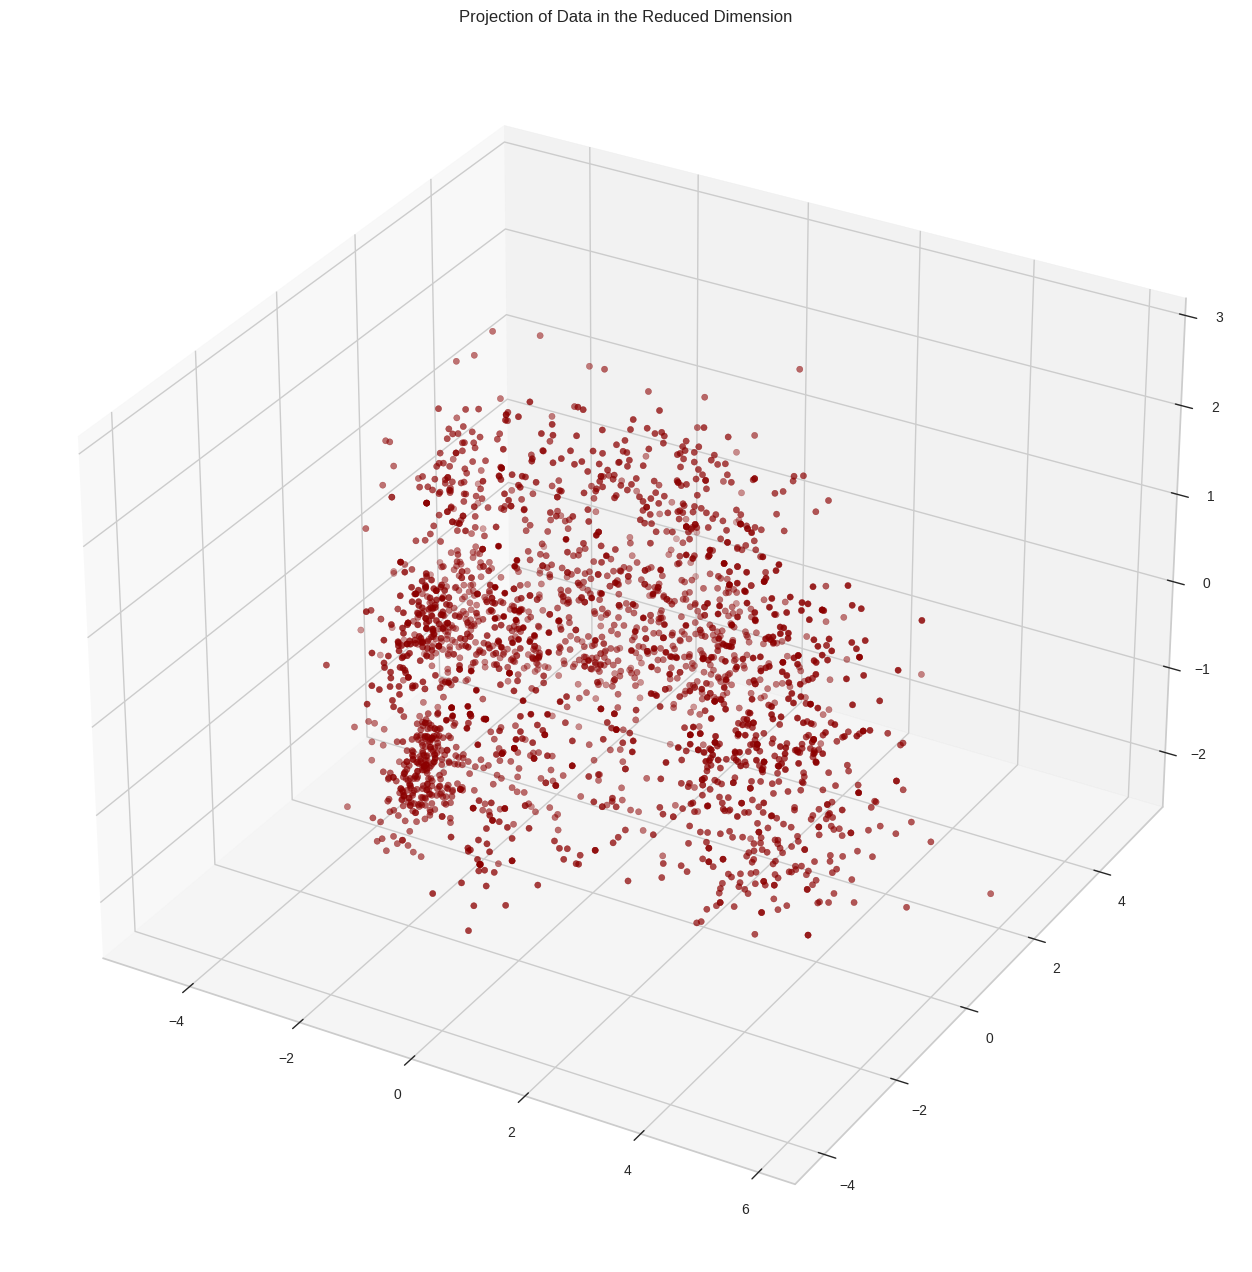

In [ ]:
# 3D data visualisation in reduced dimension
x = PCA_df["col1"]
y = PCA_df["col2"]
z = PCA_df["col3"]

fig = plt.figure(figsize=(18, 16))
ax = fig.add_subplot(111, projection = "3d")
ax.scatter(x, y, z, c = "darkred", marker = "o")
ax.set_title("Projection of Data in the Reduced Dimension")
plt.show()

## Clustering by Kmeans

Agglomerative clustering will be performed. This is a hierarchical clustering method and it involves using examples until the desired number of clusters is achieved.

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

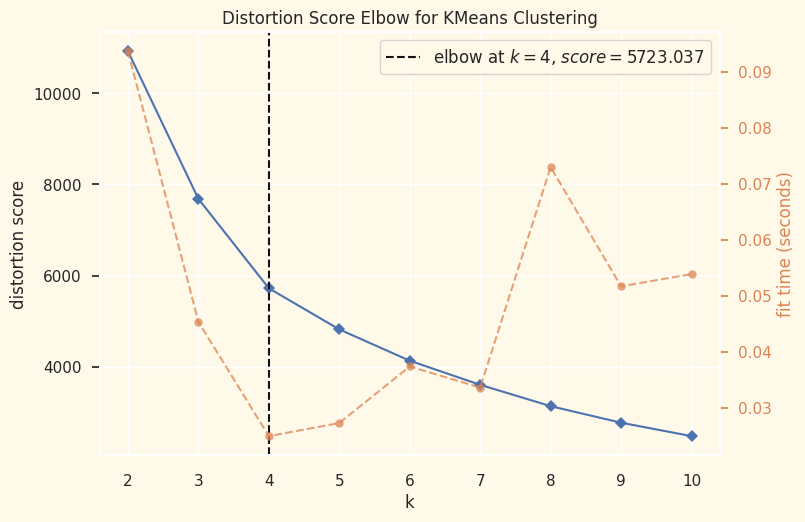

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [ ]:
# Elbow method to find number of clusters to generate
elbow = KElbowVisualizer(KMeans(), k=10)
elbow.fit(PCA_df)
elbow.show()

The Elbow Method plot above indicates that the optimal number of clusters for this data set is 4.
The next step is to fit the Kmeans Clustering Model to produce the final clusters.

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

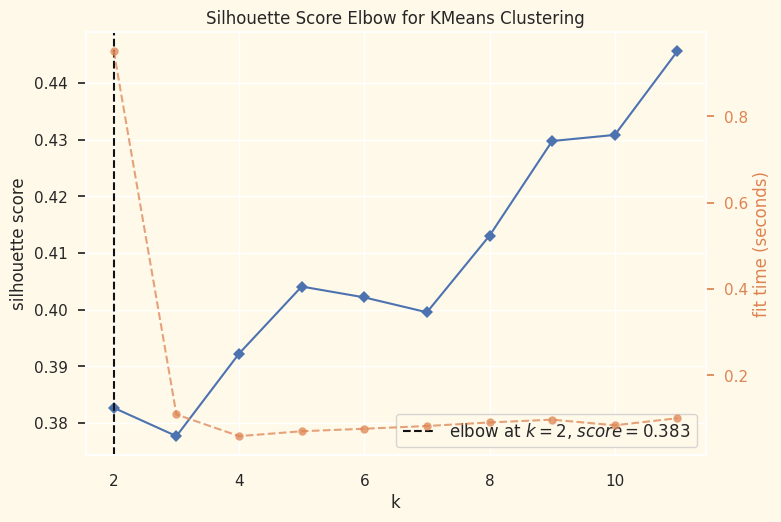

<Axes: title={'center': 'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [ ]:
#- Silhouette score -
model = KMeans()
visualizer = KElbowVisualizer(model, k=11, metric='silhouette')
visualizer.fit(PCA_df)        # Fit the data to the visualizer
visualizer.show()

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

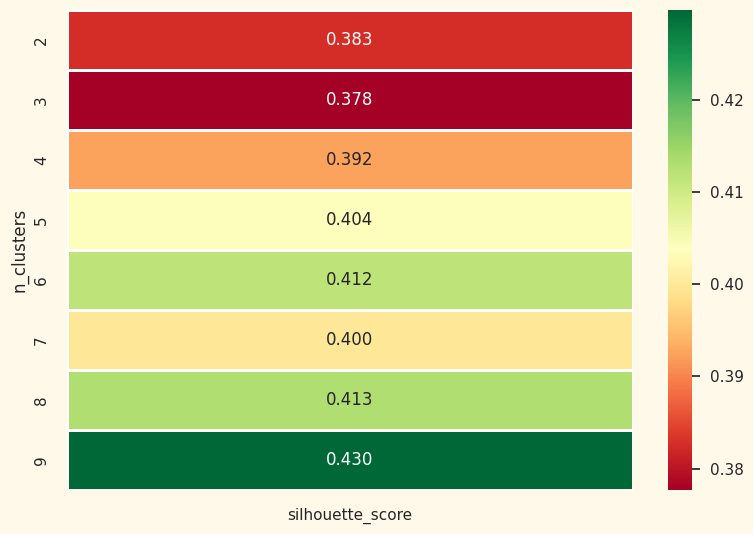

In [ ]:
from sklearn.metrics import silhouette_score
def visualize_silhouette_layer(data):
    clusters_range = range(2,10)
    results = []

    for i in clusters_range:
        km = KMeans(n_clusters=i, random_state=42)
        cluster_labels = km.fit_predict(data)
        silhouette_avg = silhouette_score(data, cluster_labels)
        results.append([i, silhouette_avg])

    result = pd.DataFrame(results, columns=["n_clusters", "silhouette_score"])
    pivot_km = pd.pivot_table(result, index="n_clusters", values="silhouette_score")

    plt.figure()
    sns.heatmap(pivot_km, annot=True, linewidths=1, fmt='.3f', cmap='RdYlGn')
    plt.tight_layout()
    plt.show()

visualize_silhouette_layer(PCA_df)

In [ ]:
from sklearn import cluster
kmeans = cluster.KMeans(n_clusters=4, n_init=10)
kmeans.fit(PCA_df)
clusters = kmeans.predict(PCA_df) + 1

In [ ]:
df.drop('Kmeans', axis=1, inplace=True)

In [ ]:
df["Kmeans"] = kmeans.predict(PCA_df) + 1
np.unique(clusters, return_counts=True)

(array([1, 2, 3, 4], dtype=int32), array([493, 512, 606, 601]))

Visualise 3D distribution of formed clusters

NameError: name 'cmap' is not defined

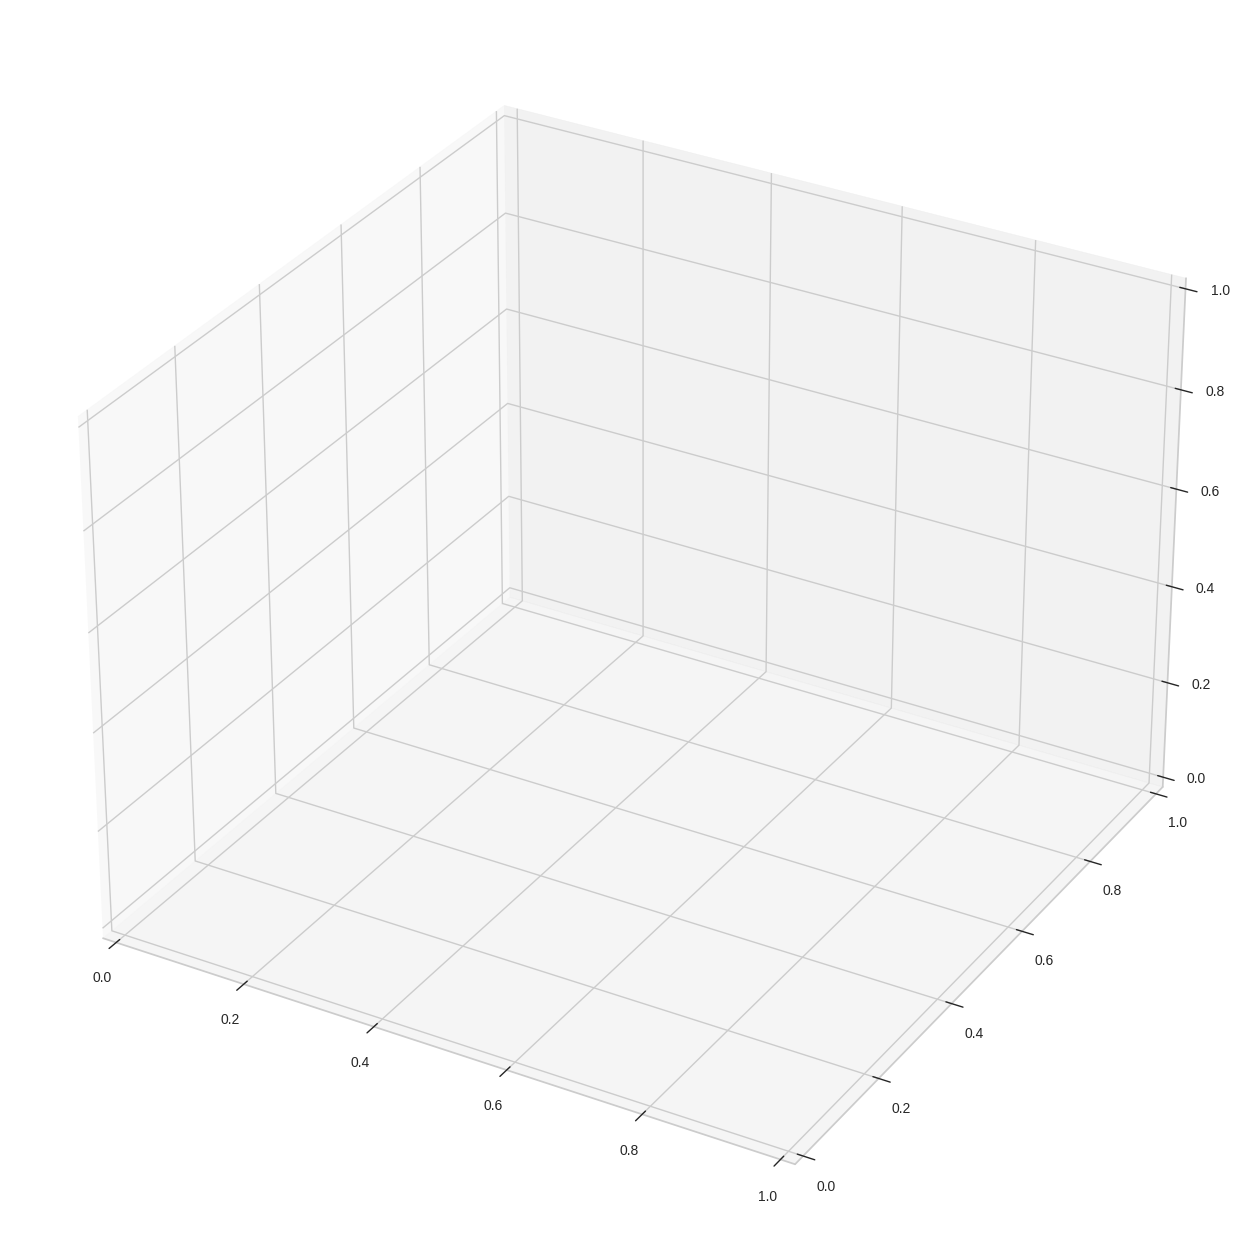

In [ ]:
# Plot clusters
PCA_df['Kmeans'] = clusters
fig_3d = plt.figure(figsize=(18,16))
ax = plt.subplot(111, projection="3d", label="bla")
ax.scatter(x, y, z, s=40, c=PCA_df["Kmeans"], marker="o", cmap=cmap)
ax.set_title("3D Projection of Newly Formed Kmeans")
plt.show()
PCA_df.drop('Kmeans', axis=1, inplace=True)

As this type of clusterin is unsupervised, there is no tagged feature to evaluare or score our model. Therefore, this section will study the patterns in the clusters formed and detemine the nature of these patterns.

For this, exploratory data analysis (EDA) will be conducted and conclusions will therefore be drawn.

<ipython-input-37-bbe33186af5f>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bar_plot = sns.countplot(x=df["Kmeans"], palette=bar_pallet)


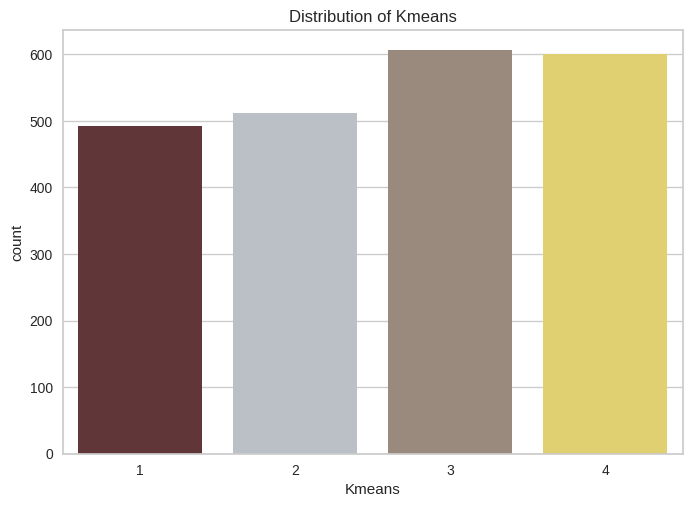

In [ ]:
# Plot bar chart of cluster sizes
bar_pallet = ["#682F33", "#B9C0C9", "#9F8A78", "#F3DD60"]
bar_plot = sns.countplot(x=df["Kmeans"], palette=bar_pallet)
bar_plot.set_title("Distribution of Kmeans")
plt.show()

As observed in the bar plot, the clusters seem to be distributed somewhat evenly.

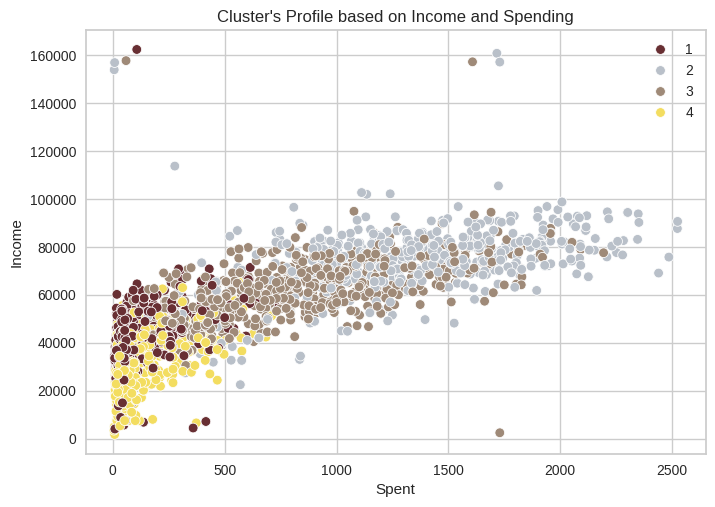

In [ ]:
# Plot scatterplot
sct_plot = sns.scatterplot(data=df, x=df["Spent"], y=df["Income"],
                           hue=df["Kmeans"], palette=bar_pallet)
sct_plot.set_title("Cluster's Profile based on Income and Spending")
plt.legend()
plt.show()

The following patterns are identified:
- Group 0: average spending & average income
- Group 1: low spending & low income
- Group 2: high spending & high income
- Group 3: low spending & high income

Namely, the detailed distribution of clusters according to various products will be examined. These products include: Wines, Fruits, Meat, Fish, Sweets and Gold.

/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:3398: UserWarning: 37.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:3398: UserWarning: 40.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:3398: UserWarning: 48.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:3398: UserWarning: 48.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
<ipython-input-92-66459639691f>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will

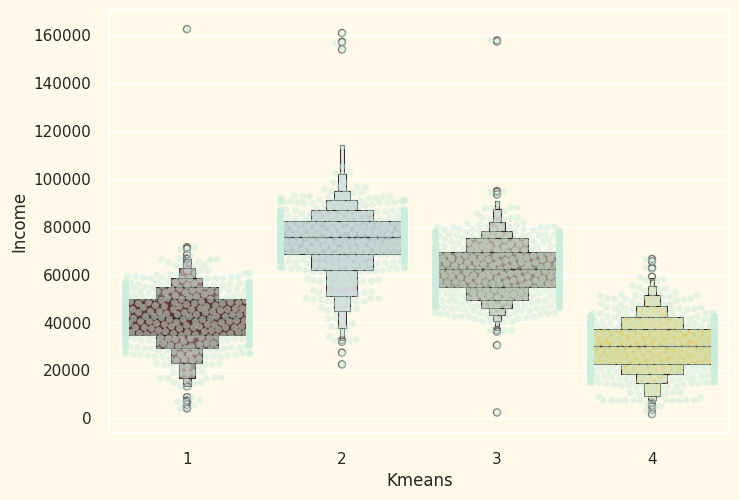

In [ ]:
plt.figure()
det_dis = sns.swarmplot(x=df["Kmeans"], y=df["Income"], color="#CBEDDD",
                      alpha=0.5)
det_dis = sns.boxenplot(x=df["Kmeans"], y=df["Income"], palette=bar_pallet)
plt.show()

/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:3398: UserWarning: 57.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:3398: UserWarning: 12.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:3398: UserWarning: 68.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
<ipython-input-93-10ed7a8085a8>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  det_dis = sns.boxenplot(x=df["Kmeans"], y=df["Spent"], palette=bar_pallet)
/usr/local/lib/python3.10/dist-packages/se

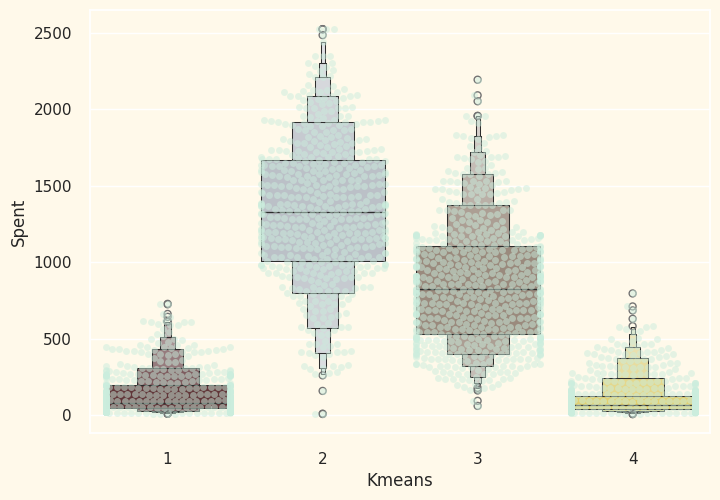

In [ ]:
plt.figure()
det_dis = sns.swarmplot(x=df["Kmeans"], y=df["Spent"], color="#CBEDDD",
                      alpha=0.5)
det_dis = sns.boxenplot(x=df["Kmeans"], y=df["Spent"], palette=bar_pallet)
plt.show()

It can be observed that Cluster 2 is the largest set of customers, very closely followed by Cluster 0. Further marketing value can be extracted from exploration of each cluster's spending habits for targeted marketing strategies.

Next, the previous campaigns' performance will be assessed

In [ ]:
means = df.groupby(['Kmeans']).agg({'Family_Size': 'mean',
                                                     'Income': 'mean',
                                                     'Age': 'mean',
                                                     'Recency': 'mean',
                                                     'Frequency': 'mean',
                                                     'Monetary': 'mean'})
# Calculate the count of records (rows) in each cluster
counts = df['Kmeans'].value_counts().reset_index()
counts.columns = ['Kmeans', 'Count']

# Merge the mean and count DataFrames
result = pd.merge(means, counts, on='Kmeans')
result

Kmeans  Family_Size        Income        Age    Recency  Frequency  \
0       1     3.603239  41906.356275  57.805668  49.192308   9.929150   
1       2     1.591797  74860.929688  55.226562  49.148438  20.005859   
2       3     2.760726  62434.196370  58.379538  48.858086  21.420792   
3       4     2.440000  30112.050000  45.715000  48.930000   8.018333   

      Monetary  Count  
0   142.605263    494  
1  1335.166016    512  
2   862.668317    606  
3   110.746667    600

Overall, there have been very few participants in the campaign. Additionally, no customers took part in all 5 campaigns.
Perhaps better-targeted and better-planned campaigns are required in order to boost sales.

Unlike the promotional campaigns, the promotional deals performed well. The best outcomes are highlighted with Clusters 0 and 3. However, the premium customers from Cluster 2 do not appear to be affected by promotional deals. Additionally, Cluster 2 customers do not appear to be overwhelmingly attracted.

# Agglomerative Hierarchical Clustering

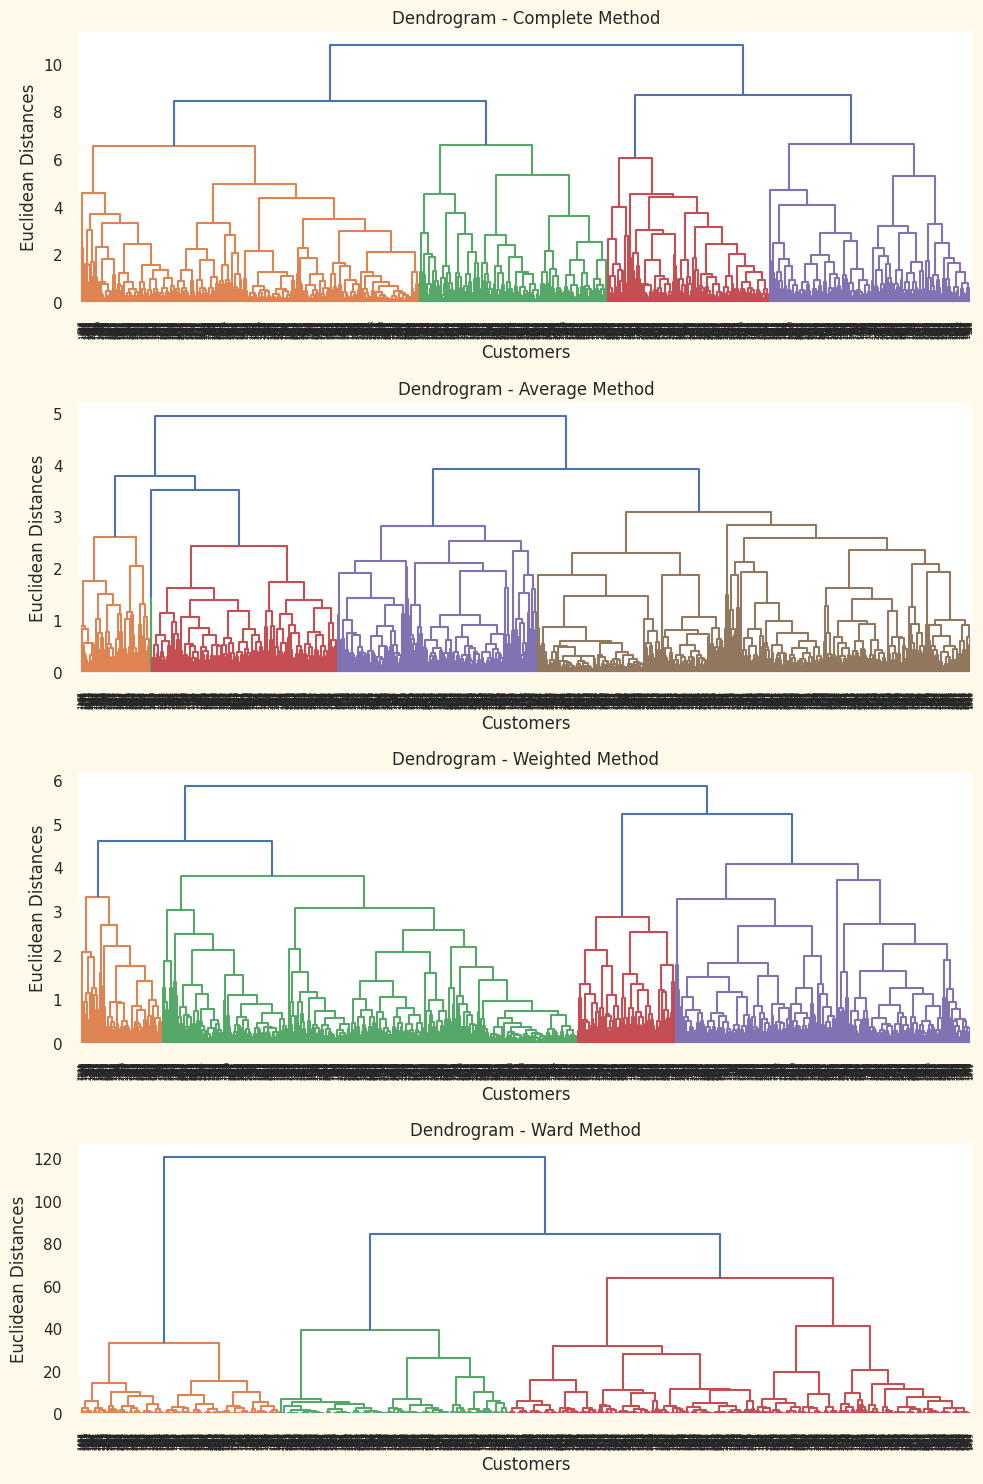

In [ ]:
from sklearn.cluster import AgglomerativeClustering, DBSCAN
from scipy.cluster import hierarchy

# Dendrogram for different linkage method
methods = [
          #'single',
          'complete',
          'average',
          'weighted',
          #'centroid',
          #'median',
          'ward']

fig, axes = plt.subplots(len(methods), 1, figsize=(10, 15))

for i, method in enumerate(methods):
    linkage_matrix = hierarchy.linkage(PCA_df, method=method)

    # Create the dendrogram
    dendro = hierarchy.dendrogram(linkage_matrix, ax=axes[i])

    axes[i].set_title(f'Dendrogram - {method.capitalize()} Method')
    axes[i].set_xlabel('Customers')
    axes[i].set_ylabel('Euclidean Distances')

plt.tight_layout()
plt.show()

According to the above results, the best method linkage is "complete"

In [ ]:
agglo = AgglomerativeClustering(n_clusters=4,
                                affinity = 'euclidean', linkage = 'complete')
agglo.fit(PCA_df)



/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


AgglomerativeClustering(affinity='euclidean', linkage='complete', n_clusters=4)

# Visualzation of the customer segmentation by Agglomerative

In [ ]:
labels = agglo.labels_ + 1
np.unique(labels, return_counts=True)

(array([1, 2, 3, 4]), array([500, 468, 402, 842]))

In [ ]:
df['Agglomerative'] = labels
PCA_df['Agglomerative'] = labels

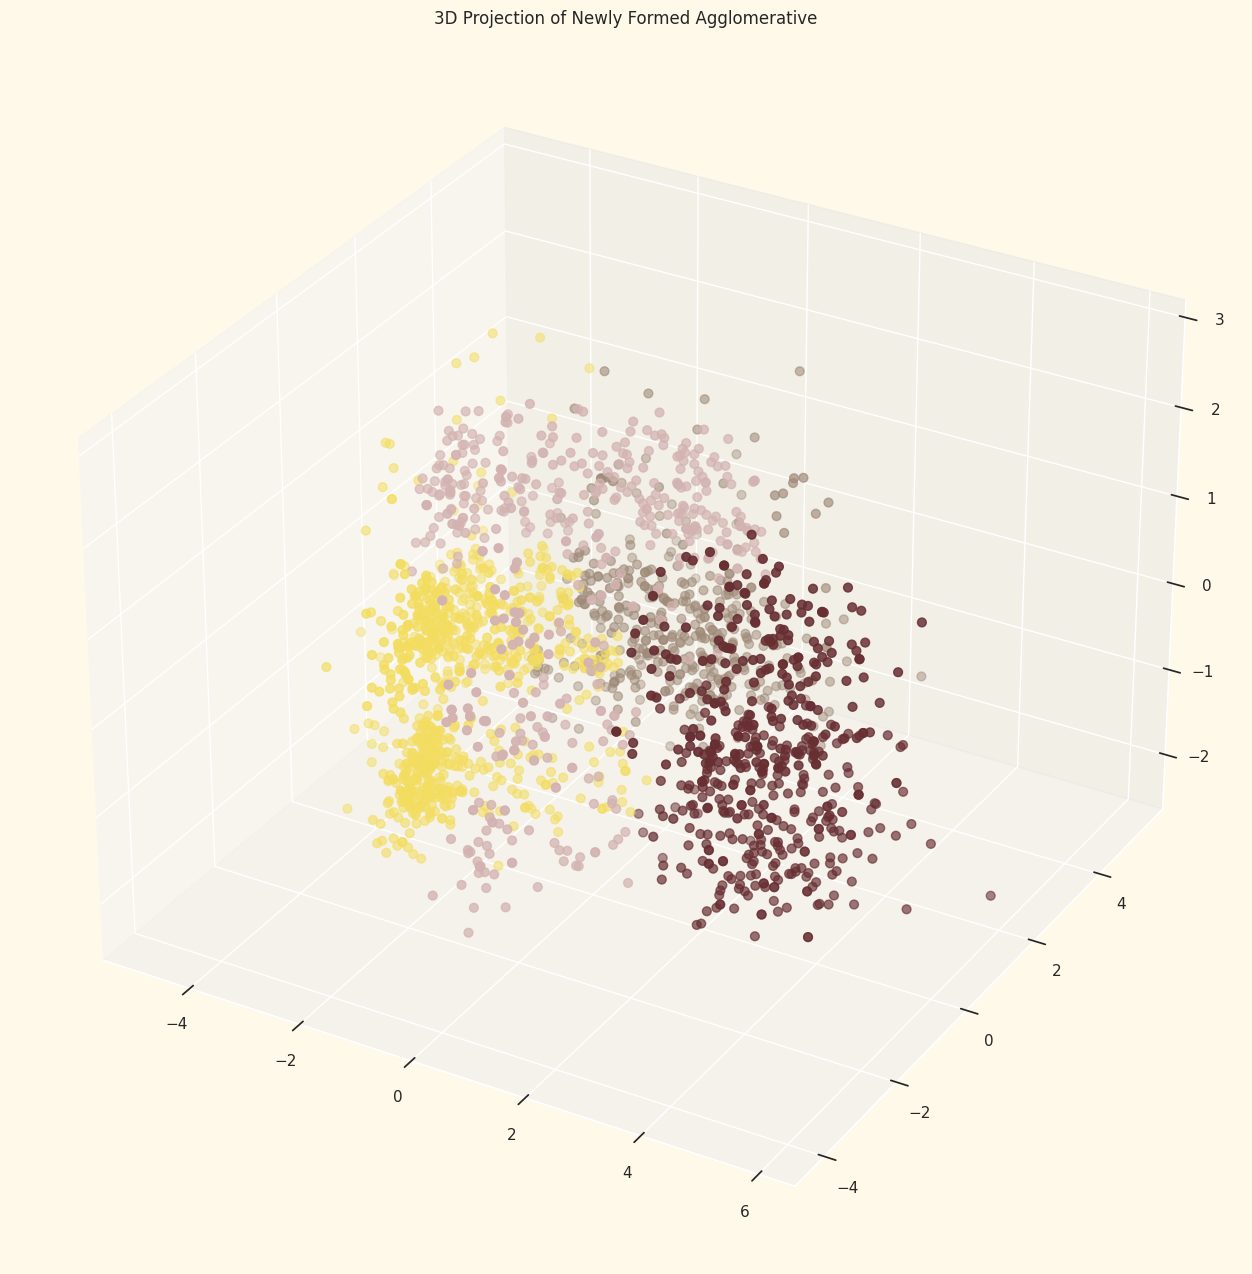

In [ ]:
# Plot clusters
fig_3d = plt.figure(figsize=(18,16))
ax = plt.subplot(111, projection="3d", label="bla")
ax.scatter(x, y, z, s=40, c=PCA_df["Agglomerative"], marker="o", cmap=cmap)
ax.set_title("3D Projection of Newly Formed Agglomerative")
plt.show()
PCA_df.drop('Agglomerative', axis=1, inplace=True)

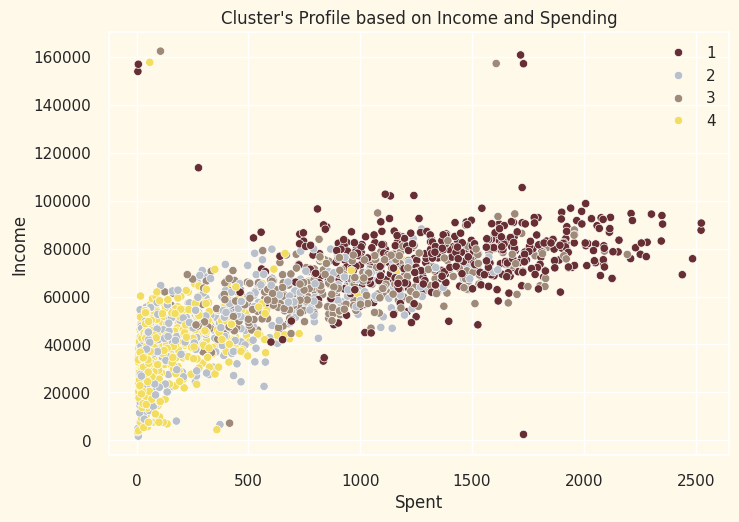

In [ ]:
# Plot scatterplot
sct_plot = sns.scatterplot(data=df, x=df["Spent"], y=df["Income"],
                           hue=df["Agglomerative"], palette=bar_pallet)
sct_plot.set_title("Cluster's Profile based on Income and Spending")
plt.legend()
plt.show()

/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:3398: UserWarning: 42.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:3398: UserWarning: 16.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:3398: UserWarning: 33.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:3398: UserWarning: 53.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
<ipython-input-101-6106c0be5f6f>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and wil

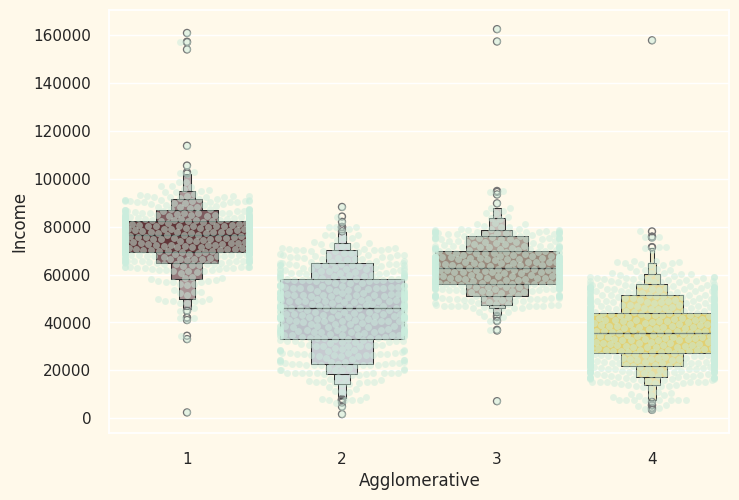

In [ ]:
plt.figure()
det_dis = sns.swarmplot(x=df["Agglomerative"], y=df["Income"], color="#CBEDDD",
                      alpha=0.5)
det_dis = sns.boxenplot(x=df["Agglomerative"], y=df["Income"], palette=bar_pallet)
plt.show()

/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:3398: UserWarning: 26.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:3398: UserWarning: 70.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
<ipython-input-102-61674b115a42>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  det_dis = sns.boxenplot(x=df["Agglomerative"], y=df["Spent"], palette=bar_pallet)
/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:3398: UserWarning: 10.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.10/dist-pac

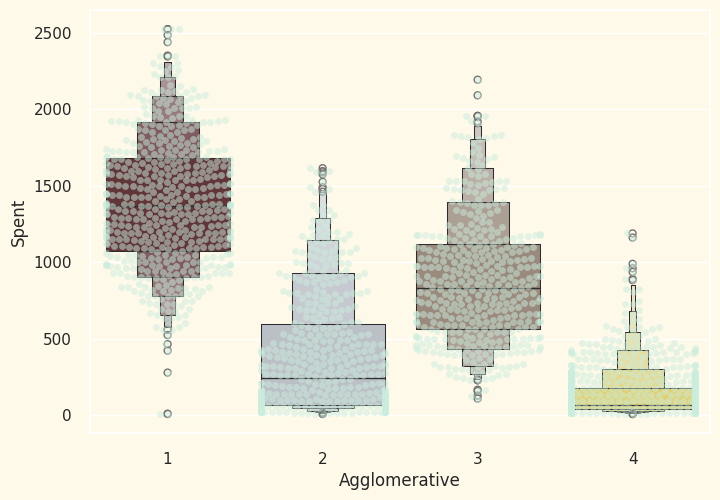

In [ ]:
plt.figure()
det_dis = sns.swarmplot(x=df["Agglomerative"], y=df["Spent"], color="#CBEDDD",
                      alpha=0.5)
det_dis = sns.boxenplot(x=df["Agglomerative"], y=df["Spent"], palette=bar_pallet)
plt.show()

# Clustering by DBSCAN

In [ ]:
dbscan = DBSCAN(eps=1.2, min_samples=20)
dbscan.fit(PCA_df)

DBSCAN(eps=1.2, min_samples=20)

#Visualization of the customer segmentation by DBSCAN

In [ ]:
PCA_df['DBSCAN']=dbscan.labels_ + 1
df['DBSCAN']=dbscan.labels_ + 1
df['DBSCAN'].value_counts()

1    2174
0      38
Name: DBSCAN, dtype: int64

In [ ]:
labels = dbscan.labels_ + 1
np.unique(labels, return_counts=True)

(array([0, 1]), array([  38, 2174]))

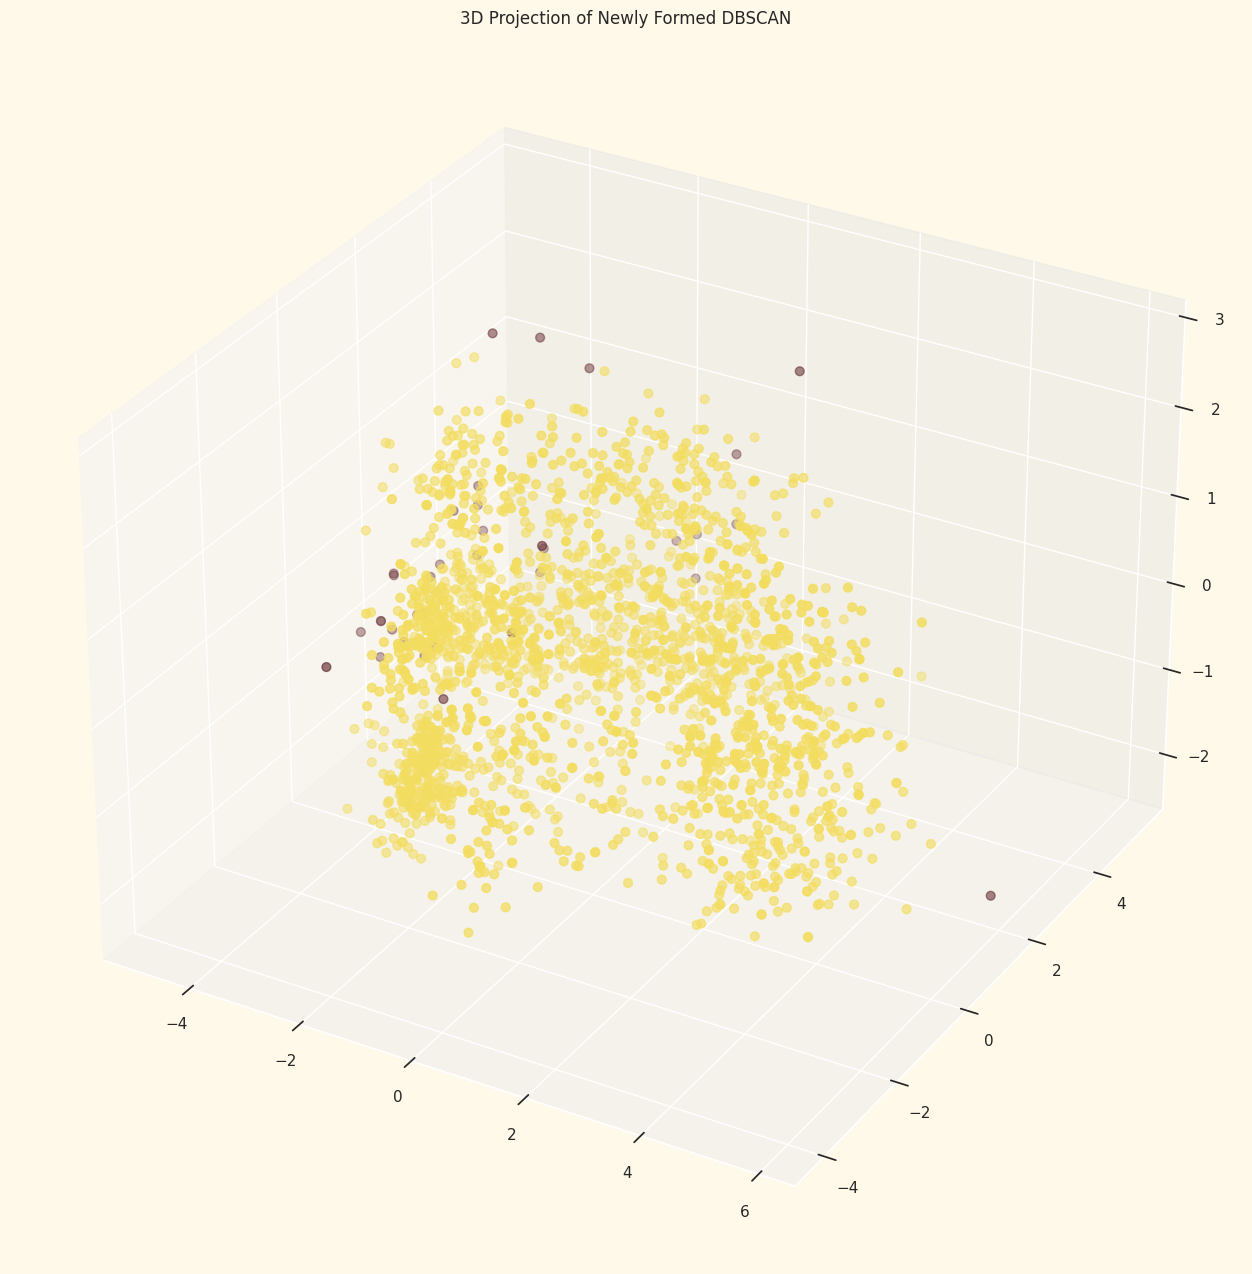

In [ ]:
# Plot clusters
fig_3d = plt.figure(figsize=(18,16))
ax = plt.subplot(111, projection="3d", label="bla")
ax.scatter(x, y, z, s=40, c=PCA_df["DBSCAN"], marker="o", cmap=cmap)
ax.set_title("3D Projection of Newly Formed DBSCAN")
plt.show()
PCA_df.drop('DBSCAN', axis=1, inplace=True)

#Clustering by HDBSCAN

In [ ]:
!pip install hdbscan

In [ ]:
import hdbscan
hdbscan = hdbscan.HDBSCAN(min_samples=20)
hdbscan.fit(PCA_df)

HDBSCAN(min_samples=20)

In [ ]:
labels = agglo.labels_ + 1
np.unique(labels, return_counts=True)

(array([1, 2, 3, 4]), array([500, 468, 402, 842]))

In [ ]:
PCA_df['HDBSCAN']=hdbscan.labels_ + 1
df['HDBSCAN']=hdbscan.labels_ + 1
df['HDBSCAN'].value_counts()

9     364
0     316
8     294
6     273
1     255
3     191
4     191
5     151
7      75
10     73
2      29
Name: HDBSCAN, dtype: int64

#Visualization of the customer segmentation by HDBSCAN

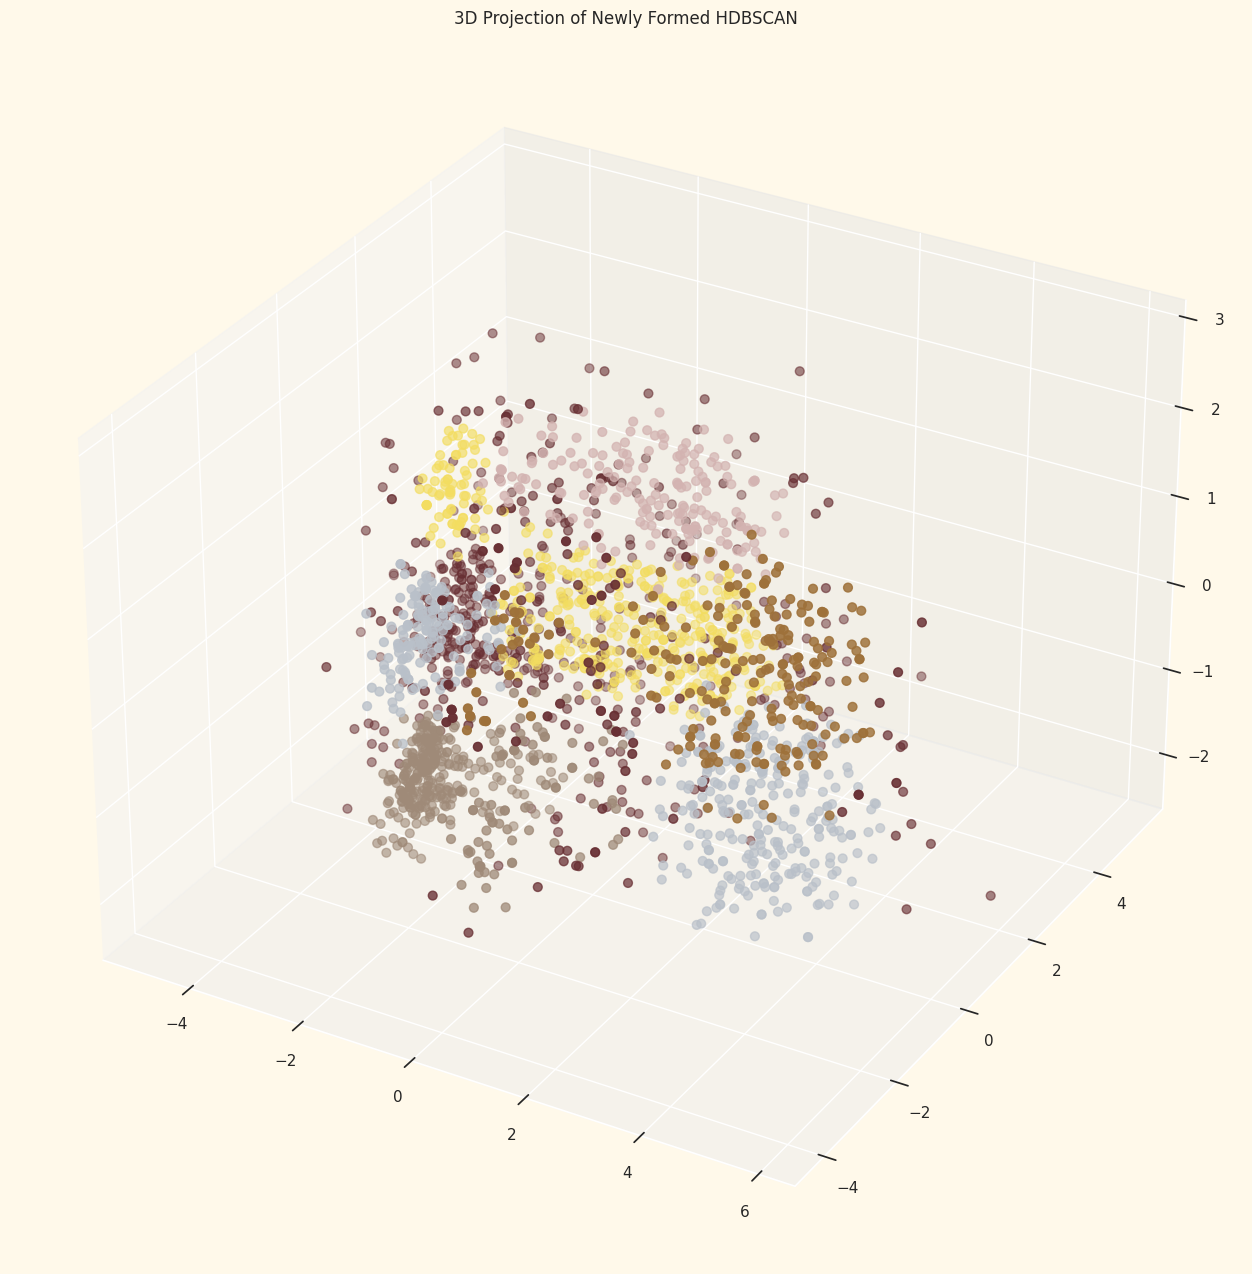

In [ ]:
# Plot clusters
fig_3d = plt.figure(figsize=(18,16))
ax = plt.subplot(111, projection="3d", label="bla")
ax.scatter(x, y, z, s=40, c=PCA_df["HDBSCAN"], marker="o", cmap=cmap)
ax.set_title("3D Projection of Newly Formed HDBSCAN")
plt.show()
PCA_df.drop('HDBSCAN', axis=1, inplace=True)

/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:3398: UserWarning: 47.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:3398: UserWarning: 56.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:3398: UserWarning: 52.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:3398: UserWarning: 48.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:3398: UserWarning: 48.3% of the points cannot be plac

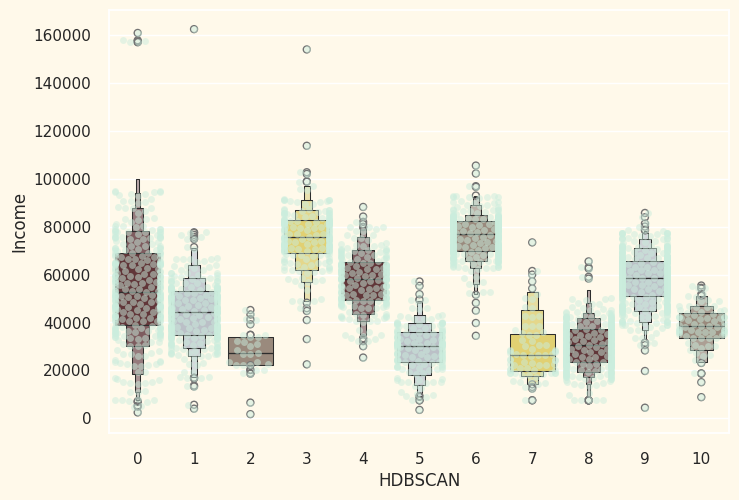

In [ ]:
plt.figure()
det_dis = sns.swarmplot(x=df["HDBSCAN"], y=df["Income"], color="#CBEDDD",
                      alpha=0.5)
det_dis = sns.boxenplot(x=df["HDBSCAN"], y=df["Income"], palette=bar_pallet)
plt.show()

/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:3398: UserWarning: 38.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:3398: UserWarning: 62.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:3398: UserWarning: 13.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:3398: UserWarning: 22.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:3398: UserWarning: 18.3% of the points cannot be plac

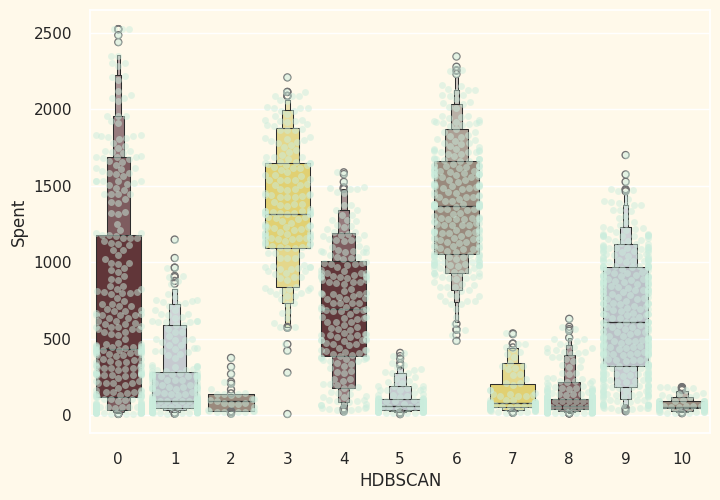

In [ ]:
plt.figure()
det_dis = sns.swarmplot(x=df["HDBSCAN"], y=df["Spent"], color="#CBEDDD",
                      alpha=0.5)
det_dis = sns.boxenplot(x=df["HDBSCAN"], y=df["Spent"], palette=bar_pallet)
plt.show()

In [ ]:
df.drop(['Agglomerative', 'DBSCAN', 'HDBSCAN'], axis=1, inplace=True)

## Profiling

Clusters will now be profiled to establish the customers' characteristics for each customer group and conclude on who the star customers are and who requires a higher degree of attention from the marketing team.
In order to establish this, features representing personal traits will be plotted by cluster.

# Save model

In [ ]:
import joblib

filename = "/content/drive/MyDrive/project/project_3/code/my_model.joblib"

# save model
joblib.dump(clusters, open(filename, "wb"))

#Load model

In [ ]:
#Load model
import joblib
filename = "/content/drive/MyDrive/project/project_3/code/my_model.joblib"
model = joblib.load(open(filename, "rb"))
df["Kmeans_2"] = model.predict(PCA_df) + 1
np.unique(clusters, return_counts=True)

In [ ]:
Personal_Traits = ["Kidhome", "Teenhome", "Customer_For", "Age", "Children", "Family_Size", "Is_Parent", "Education", "Living_With"]

for trait in Personal_Traits:
    plt.figure()
    sns.jointplot(x=df[trait], y=df["Spent"], hue=df["Kmeans"], kind="kde", palette=bar_pallet)
    plt.show()

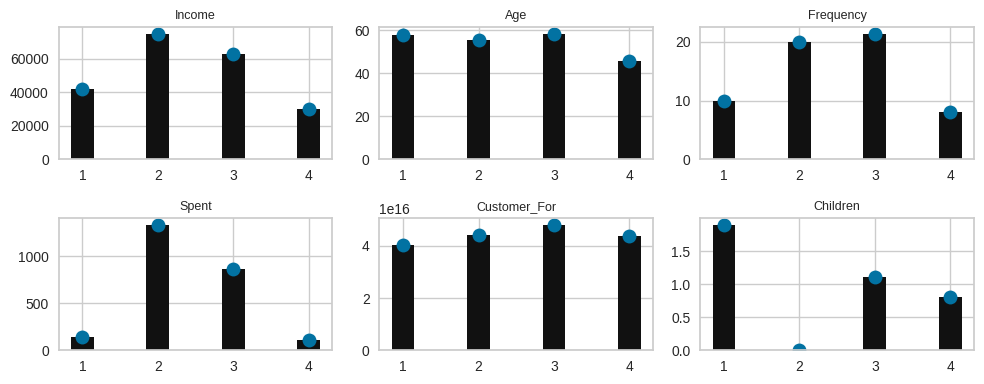

In [ ]:
other_num_cols = ['Income', 'Age', 'Frequency', 'Spent', 'Customer_For', 'Children']

fig, axes = plt.subplots(2, 3, figsize=(10, 4))
data = df.groupby("Kmeans")[other_num_cols].mean()
axes = axes.flatten()
for col, ax in zip(other_num_cols, axes):
    data.sort_values(by=col, ascending=False, inplace=True)
    ax.plot(data.index, data[col], marker="o", ls="", ms=10)
    ax.bar(data.index, data[col], width=0.3, color="k")
    ax.set_title(f"{col}", size=9)
plt.tight_layout()

### About Cluster Number 0:
- Definitely a parent
- Betweent 2 and 4 family members
- Most have a teenager at home
- In the older age groups

### About Cluster Number 1:
- Majority are parents
- Max 3 family members
- Majority have 1 kid (typically not teenagers)
- In the younger age groups

### About Cluster Number 2:
- Definitely not a parent
- Max 2 members in the family
- Slight majority of couples over single people
- Span all age groups
- High income group

### About Cluster Number 4:
- Definitely a parent
- Between 2 and 5 family members
- Majority have 1 teenager at home
- In the older age groups
- Low income group

## Conclusion

Throughout this project, unsupervised clustering has been performed. Dimensionality reducation was employed, followed by agglomerative clustering. Four clusters have been produced and used for customer profiling per cluster according to their household structures, income and spending. The information extracted can be used for planning future marketing strategies.